In [1]:
#Run Keras Tuner to find optimized neural network

# Preprocessing - Scale data
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from kerastuner.tuners import BayesianOptimization

# Retrieve Training and Testing Data
df_train = pd.read_csv('data/trainClean.csv')
df_test = pd.read_csv('data/testClean.csv')

X_train = df_train.drop(columns='Transported')
y_train = df_train['Transported']

# Preprocessing - Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define hypermodel for hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=13, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Add variable number of hidden layers and their sizes
    for i in range(hp.Int('num_hidden_layers', 1, 10)):
        model.add(Dense(units=hp.Int(f'layer_{i}_units', min_value=2, max_value=512, step=2), activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.01)))
    
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile the model

    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

# Instantiate the BayesianOptimization tuner
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=1000,
    directory='keras_tuner_logs',
    project_name='my_hyperparameter_search',
    distribution_strategy=tf.distribute.MirroredStrategy()
)


# Perform the hyperparameter search with Early Stopping callback
tuner.search(X_train_scaled, y_train, epochs=30, validation_split=0.2, batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

#Print the best hyperparameters
print(best_hps.get_config())

# Build the model using the best hyperparameters
best_model = build_model(best_hps)

# Train the best model using all training data
best_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32)

# Prepare test data for predictions
X_test_scaled = scaler.transform(df_test)

# Predict using the best model on test data
predictions = best_model.predict(X_test_scaled)
pred = (predictions > 0.5).astype(int)

tfMap = {0: False, 1: True}

kaggleCSV = pd.DataFrame(columns=['PassengerId', 'Transported'])
kaggleCSV['PassengerId'] = df_test['PassengerId']
kaggleCSV['Transported'] = [tfMap[i[0]] for i in pred]

# Save predictions to a CSV file
kaggleCSV.to_csv('results/nn_results.csv', index=False)


Trial 1000 Complete [00h 00m 14s]
val_accuracy: 0.7809085845947266

Best val_accuracy So Far: 0.8113858699798584
Total elapsed time: 05h 40m 32s
{'space': [{'class_name': 'Int', 'config': {'name': 'num_hidden_layers', 'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'layer_0_units', 'default': None, 'conditions': [], 'min_value': 2, 'max_value': 512, 'step': 2, 'sampling': 'linear'}}, {'class_name': 'Float', 'config': {'name': 'dropout_rate', 'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'layer_1_units', 'default': None, 'conditions': [], 'min_value': 2, 'max_value': 512, 'step': 2, 'sampling': 'linear'}}, {'class_name': 'Int', 'config': {'name': 'layer_2_units', 'default': None, 'conditions': [], 'min_value': 2, 'max_value': 512, 'step': 2, 'sampling': 'linear'}}, {'class_name': 'Int', 'con

Epoch 1/30
272/272 [==============================] - 1s 1ms/step - loss: 0.7797 - accuracy: 0.5105
Epoch 2/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5975 - accuracy: 0.5272
Epoch 3/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5786 - accuracy: 0.5101
Epoch 4/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5301 - accuracy: 0.5146
Epoch 5/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5436 - accuracy: 0.5741
Epoch 6/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5312 - accuracy: 0.5523
Epoch 7/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5034 - accuracy: 0.5011
Epoch 8/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5294 - accuracy: 0.4986
Epoch 9/30
272/272 [==============================] - 0s 1ms/step - loss: 0.5034 - accuracy: 0.5175
Epoch 10/30
272/272 [==============================] - 0s 1ms/step - loss: 0.4851 - accuracy: 0.4958

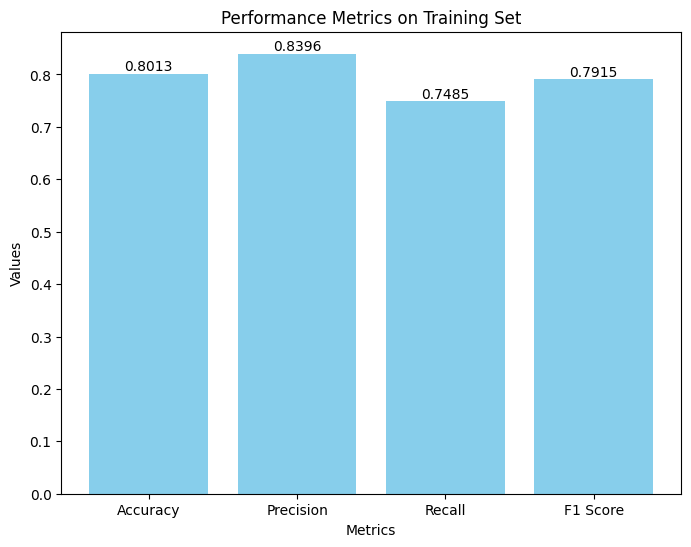

In [8]:
#Test precision, recall, and F1 score of optimized neural network

import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Retrieve Training and Testing Data
df_train = pd.read_csv('data/trainClean.csv')
df_test = pd.read_csv('data/testClean.csv')

X_train = df_train.drop(columns='Transported')
y_train = df_train['Transported']

# Preprocessing - Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

def build_model():
    model = Sequential()
    model.add(Dense(units=13, activation='relu', input_shape=(X_train.shape[1],)))
    
    # Add the specific number of hidden layers and their sizes based on the found hyperparameters
    model.add(Dense(units=450, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.42))
    
    #output layer
    model.add(Dense(units=2, activation='relu')) 
    
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

# Fit the model
model = build_model()  # Assuming 'best_hps' contains the optimal hyperparameters
model.fit(X_train_scaled, y_train, epochs=30, batch_size=32)

# Predict using the model on training data
train_predictions = model.predict(X_train_scaled)
train_pred = (train_predictions > 0.5).astype(int)

# Convert predictions to True/False
tfMap = {0: False, 1: True}
train_pred_tf = [tfMap[i[0]] for i in train_pred]

# Compute precision, recall, and F1 score on training data
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_train, train_pred_tf)
precision = precision_score(y_train, train_pred_tf)
recall = recall_score(y_train, train_pred_tf)
f1 = f1_score(y_train, train_pred_tf)

# Create a bar graph
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Performance Metrics on Training Set')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Add the numerical values on top of each bar
for i, value in enumerate(values):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

plt.show()

In [9]:
# Test default hyperparameter neural network

# Import necessary libraries
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Retrieve Training and Testing Data 
df_train = pd.read_csv('data/trainClean.csv')  # Read training data
df_test = pd.read_csv('data/testClean.csv')    # Read test data

X_train = df_train.drop(columns='Transported')  # Features for training
y_train = df_train['Transported']               # Target variable for training

# Instantiate a Multi-Layer Perceptron (MLP) Classifier with default settings
nn = MLPClassifier()

# Train the default MLP classifier using the training data
nn.fit(X_train, y_train)

# Predict using the trained model on the test data
pred = nn.predict(df_test)

# Mapping prediction values to True/False
tfMap = {0: False, 1: True}

# Create a DataFrame for predictions and map predicted values to 'Transported' column
kaggleCSV = pd.DataFrame(columns=['PassengerId', 'Transported'])
kaggleCSV['PassengerId'] = df_test['PassengerId']
kaggleCSV['Transported'] = [tfMap[i] for i in pred]

# Save predictions to a CSV file named 'nn_default_results.csv'
kaggleCSV.to_csv('results/nn_default_results.csv', index=False)



KeyError: "['Transported'] not found in axis"

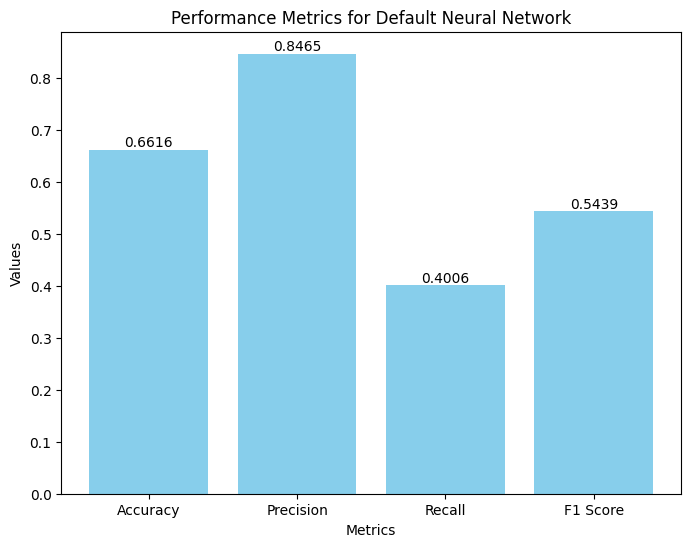

In [10]:
#Plot metrics of default neural network

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Retrieve Training and Testing Data 
df_train = pd.read_csv('data/trainClean.csv')
df_test = pd.read_csv('data/testClean.csv')

X_train = df_train.drop(columns='Transported')
y_train = df_train['Transported']

# Preprocess the data for the default model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train default hyperparameter neural network
default_nn = MLPClassifier()
default_nn.fit(X_train, y_train)

# Compute metrics for the default model
train_pred = default_nn.predict(X_train)
accuracy = accuracy_score(y_train, train_pred)
precision = precision_score(y_train, train_pred)
recall = recall_score(y_train, train_pred)
f1 = f1_score(y_train, train_pred)

# Plotting metrics
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color='skyblue')
plt.title('Performance Metrics for Default Neural Network')
plt.xlabel('Metrics')
plt.ylabel('Values')

# Display numerical values on top of each bar
for i, value in enumerate(values):
    plt.text(i, value, f'{value:.4f}', ha='center', va='bottom')

plt.show()
